# Part-A: Data preprocessing and initial setup (EDA)

### Load the dataset

In [ ]:
# import important library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Import sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

In [ ]:
# Import the dataset
df = pd.read_csv("yeast.csv")
# extract feature matrix
X = df.iloc[:, :-14].values
# extract multi-label target matrix
y = df.iloc[:, -14:].values

### Dimensionality check

In [80]:
print(X.shape)
print(y.shape)

(2417, 103)
(2417, 14)


- The initial number of features is 103.
- The number of data points (samples) is 2417.
- The number of class labels is 14.

#### Bar chart depicting the distribution of sample counts for each of the yeast class labels

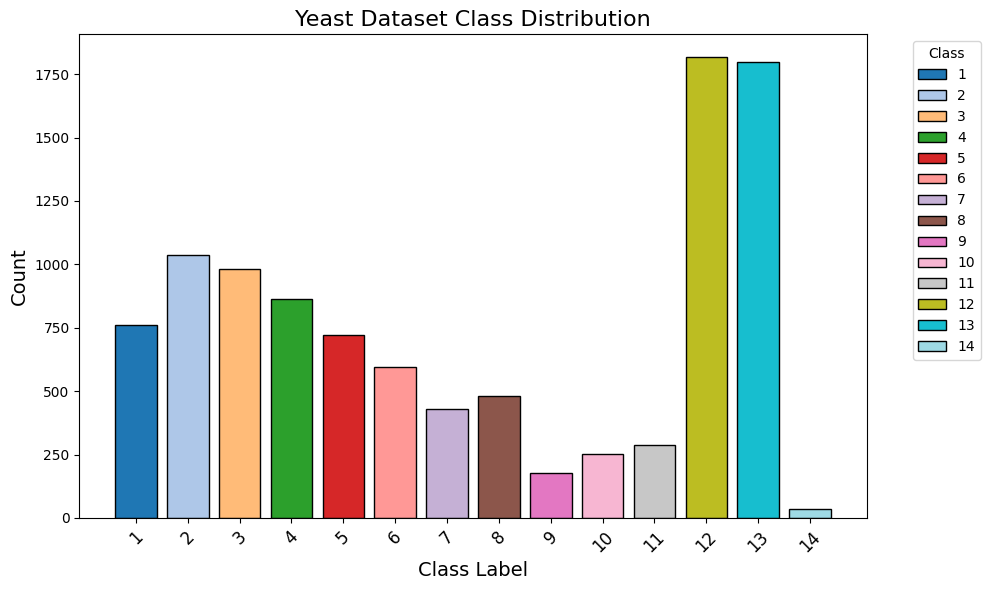

In [43]:
counts = np.sum(y, axis=0)
class_labels = [str(i) for i in range(1,15)]          # Replace with actual names if available
bar_colors = plt.cm.tab20(np.linspace(0, 1, 14))   # Use a colormap for distinct colors

plt.figure(figsize=(10, 6))
bars = plt.bar(range(14), counts, color=bar_colors, edgecolor='black')

plt.xticks(range(14), class_labels, fontsize=12, rotation=45)
plt.xlabel("Class Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Yeast Dataset Class Distribution", fontsize=16)

# Add legend for each bar
for bar, label in zip(bars, class_labels):
    bar.set_label(label)

plt.legend(fontsize=10, title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Label selection & visualization

We create 4 new target variables as per the following scheme:

- Single_0: samples of most frequent single class labels, all such samples belong to class-1 only.
- Multi_1: samples of most frequent multi-label combination.
- Multi_2: samples of 2nd most frequent multi-label combination.
- Other: samples that do not belong to any of the above categories.

**Note**: There are no samples of 2nd most frequent single class labels. All samples except those exclusively belonging to class-1 have multiple class labels.

In [81]:
# Find the most frequent single-label class
single_mask = y.sum(axis=1) == 1
single_label_indices = y[single_mask].argmax(axis=1)
if len(single_label_indices) > 0:
    top_single = Counter(single_label_indices).most_common(1)[0][0]
else:
    top_single = None

# Find the two most frequent multi-label combinations
multi_mask = y.sum(axis=1) > 1
multi_label_tuples = [tuple(row) for row in y[multi_mask]]
top_two_multi = [combo for combo, _ in Counter(multi_label_tuples).most_common(2)]

# Assign new target variable
new_target = []
for row in y:
    if row.sum() == 1 and row.argmax() == top_single:
        new_target.append(f"Single_{top_single}")
    elif tuple(row) in top_two_multi:
        idx = top_two_multi.index(tuple(row))
        new_target.append(f"Multi_{idx+1}")
    else:
        new_target.append("Other")

Study the class distribution for the newly created target variable

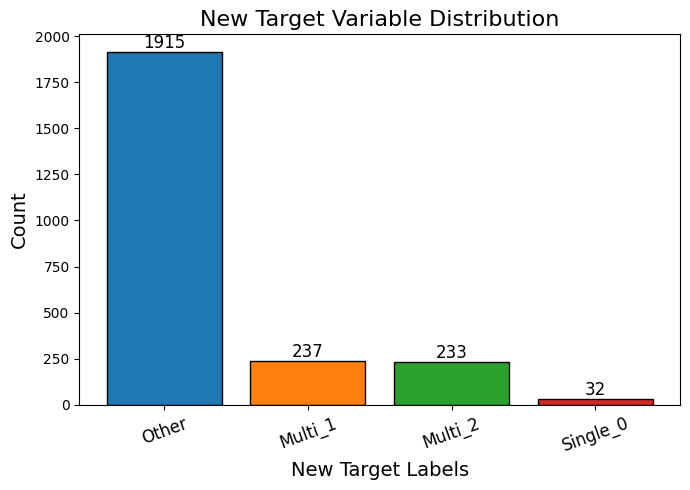

In [83]:
# Plot bar plot of the new target variable
counts = Counter(new_target)
labels, values = zip(*counts.items())
colors = plt.cm.tab10(np.arange(len(labels)))

plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=colors, edgecolor='black')
plt.xlabel("New Target Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("New Target Variable Distribution", fontsize=16)
plt.xticks(fontsize=12, rotation=20)
plt.tight_layout()

# Add count labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, int(height),
             ha='center', va='bottom', fontsize=12)

plt.show()

### Scaling

Importance of scaling before applying distance-based dimensionality reduction techniques:

- Scaling is crucial before applying distance-based dimensionality reduction techniques because features with larger value ranges will dominate the computation of distances, causing the results to be biased toward those dimensions and distorting the underlying structure of your data.

- When features are not scaled to a common range (such as zero mean and unit variance), techniques like PCA, t-SNE, or UMAP may be unduly influenced by variables with greater magnitude, making distance computations reflect scale differences rather than true similarity patterns. This can result in misleading components, suboptimal separation of clusters, and poor visualization or model performance. 

- By scaling, each feature contributes equally to the distance metrics, ensuring that dimensionality reduction methods accurately preserve the intrinsic geometry and relationships in the data.

In [ ]:
# scale the features in X
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Part B: t-SNE and Veracity Inspection

### t-SNE Implementation & Visualization

Carry out t-SNE projections of the scaled data, each with a different perplexity value, and visualize the results using 2D scatter plot with coloring scheme based on new class labels to study how the clustering structure changes with perplexity.

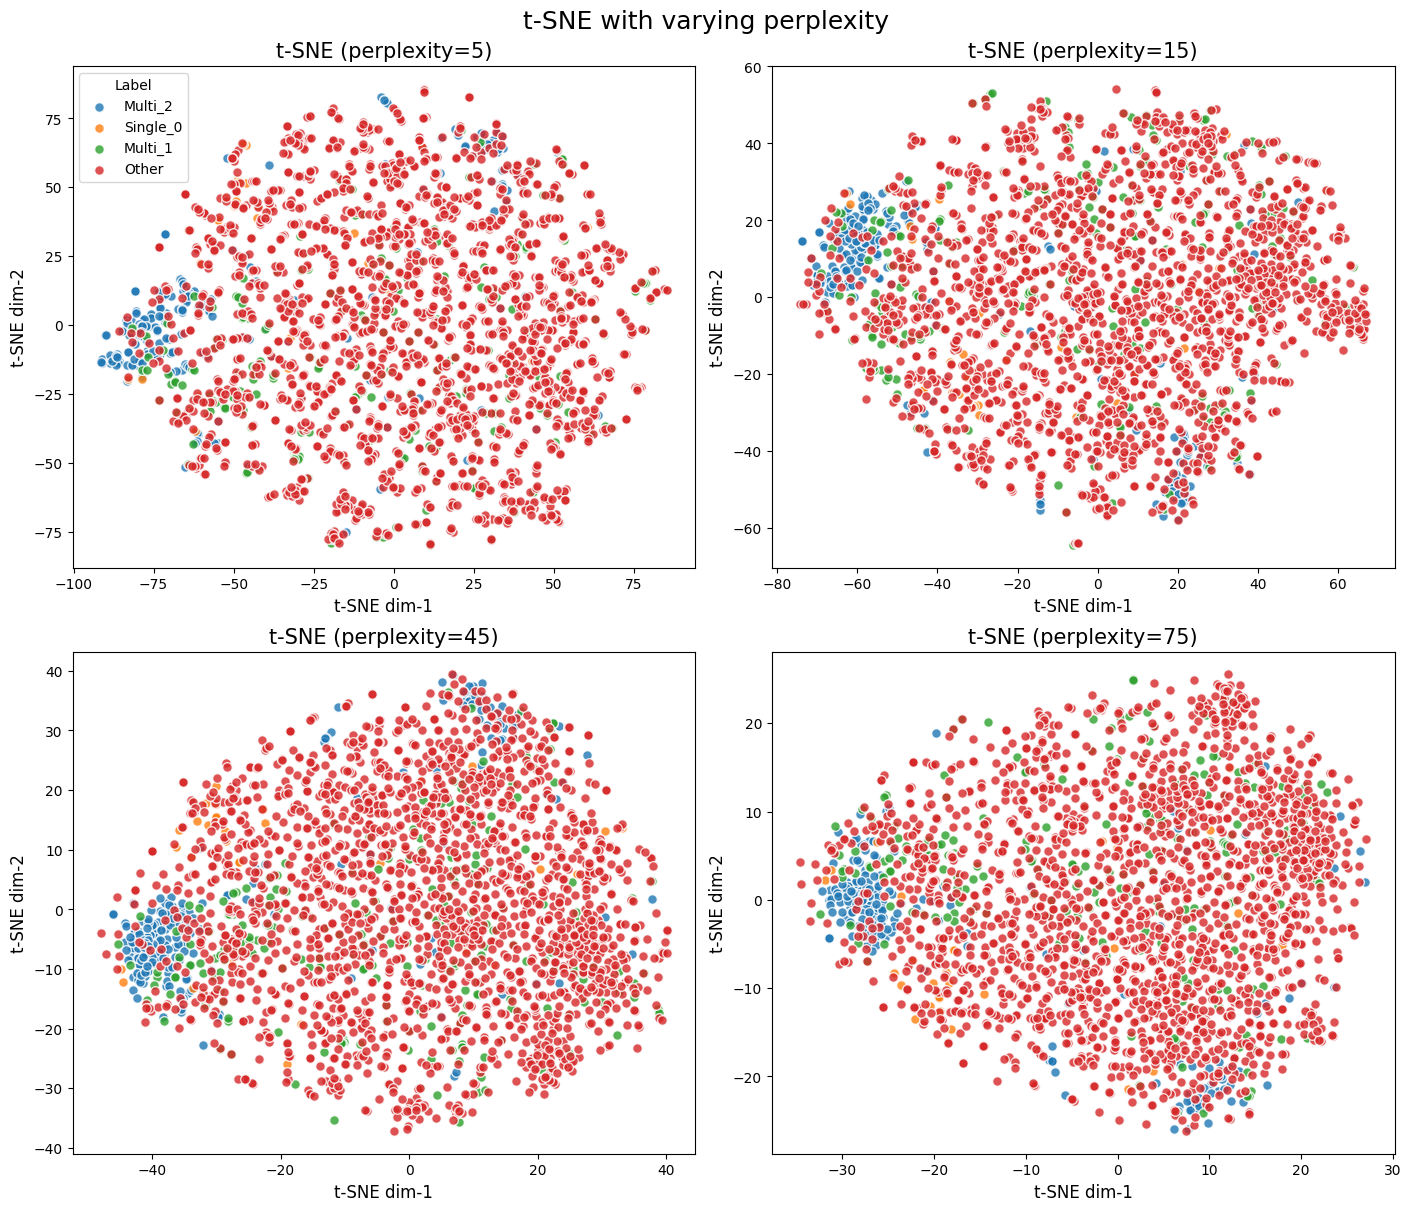

In [99]:
perplexities = [5, 15, 45, 75]
unique_labels = list(set(new_target))
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))

fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
axes = axes.flatten()

for idx, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=0)
    X_tsne = tsne.fit_transform(X_scaled)

    ax = axes[idx]
    for cat in unique_labels:
        id_cat = np.array(new_target) == cat
        ax.scatter(X_tsne[id_cat, 0], X_tsne[id_cat, 1],
                   color=color_map[cat], label=cat, alpha=0.8, edgecolors='w', s=48)
    ax.set_title(f't-SNE (perplexity={perp})', fontsize=15)
    ax.set_xlabel('t-SNE dim-1', fontsize=12)
    ax.set_ylabel('t-SNE dim-2', fontsize=12)
    if idx == 0:
        ax.legend(fontsize=10, title="Label", frameon=True, loc='best')

fig.suptitle('t-SNE with varying perplexity', fontsize=18)

plt.show()

When experimenting with the `perplexity` hyperparameter in t-SNE, as shown in the above multi-panel plot (perplexities=5, 15, 45, 75):

>Low perplexity (e.g., 5): t-SNE focuses heavily on preserving local structure; clusters appear more scattered, small clusters and local groupings are sharply separated, but global structure can be distorted.

>Intermediate perplexity (15, 45): Balance is achieved between local and global structure. Major clusters begin to stabilize, outliers and rare classes remain visible, and moderately sized groups are well distinguished.

>High perplexity (75): t-SNE increasingly emphasizes the global arrangement of data. Major clusters condense and are less likely to fragment, but fine local separations (especially of minority classes or outliers) become less distinct, and some structure is smoothed out.

#### Chosen Perplexity
45 (or close to 30)

This value offers the best compromise:
>Major clusters are clearly separated without excessive fragmentation or smoothing.
 
>Outlier and mixed regions remain identifiable.
 
>The global data geometry and relationships remain interpretable.

#### Justification for Final Choice
A moderate perplexity (such as 30 to 50) is typically optimal for datasets like this one, where both local and global patterns are of interest. In the panels, perplexities around 45 produce clear, stable clusters without over-separating small groups or excessively smoothing the data. This value reliably separates prominent classes (like “Multi_1” or dominant single-label categories) while maintaining visibility for secondary structure and avoiding noise amplification or artificial isolation of points.

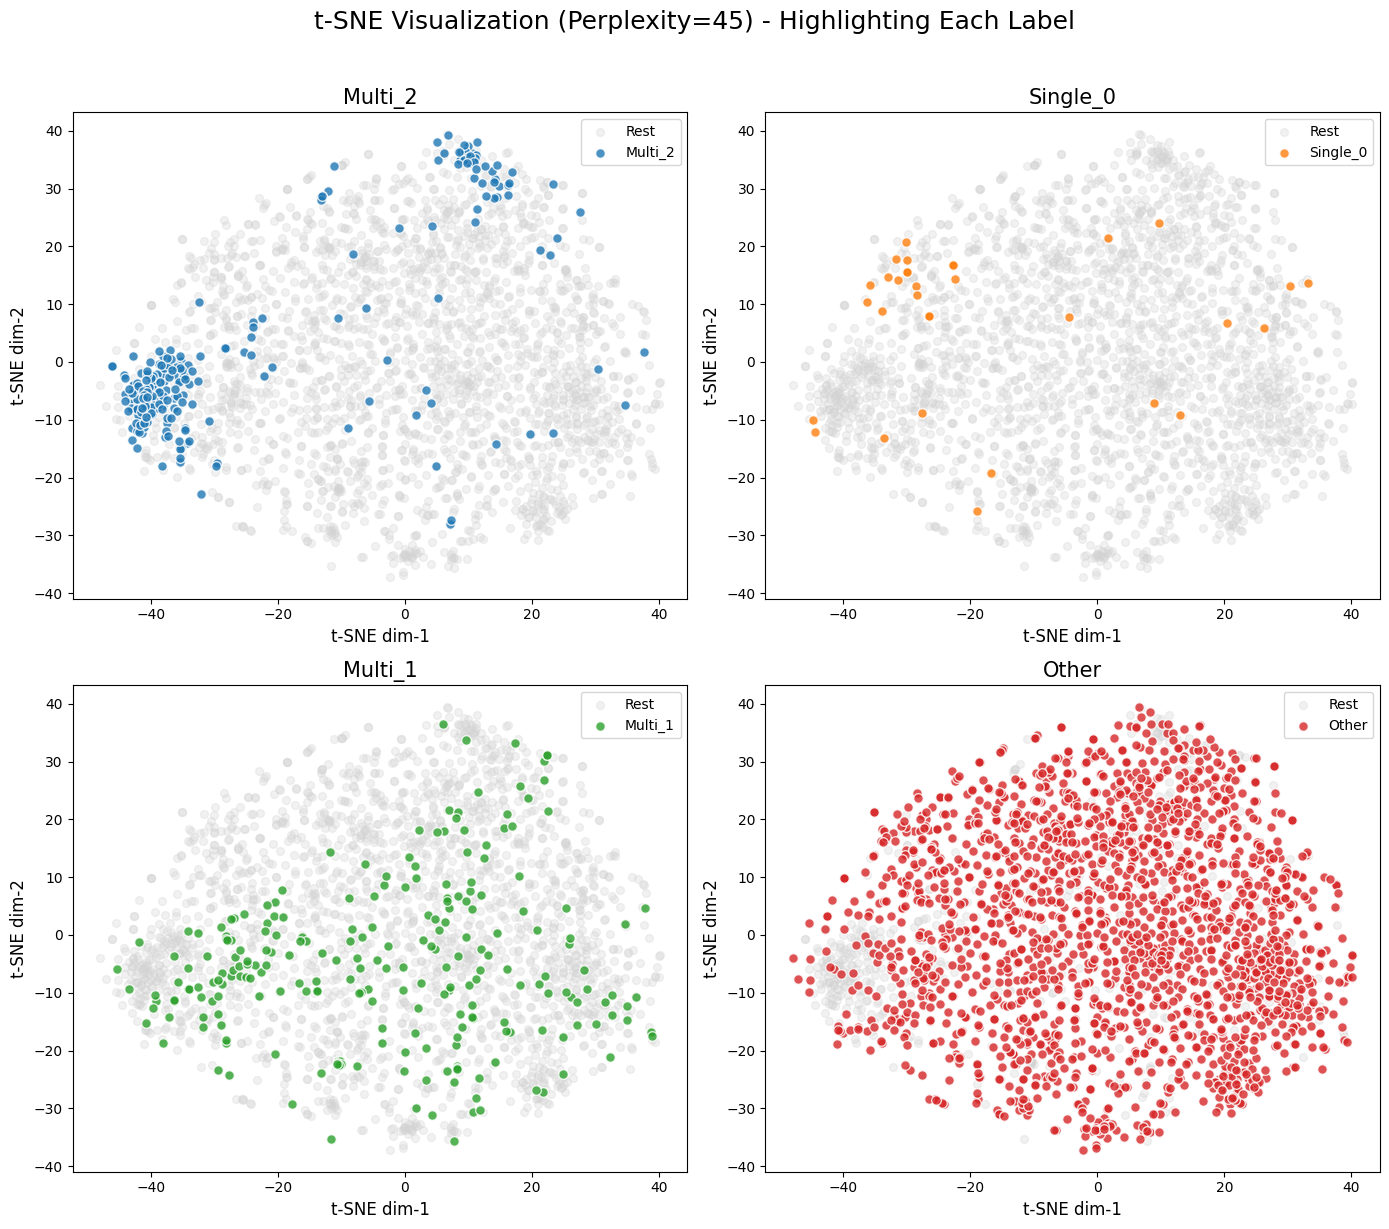

In [104]:
# scatter plot of TSNE projections of the data using perplexity=45

tsne = TSNE(n_components=2, perplexity=45, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, label in enumerate(unique_labels):
    ax = axes[idx]
    mask = np.array(new_target) == label
    # Gray out other points for context
    ax.scatter(X_tsne[~mask, 0], X_tsne[~mask, 1], color="lightgray", alpha=0.3, s=32, label='Rest')
    # Highlight only this label
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], color=color_map[label], alpha=0.8, s=48, label=label, edgecolors='w')
    ax.set_title(f'{label}', fontsize=15)
    ax.set_xlabel('t-SNE dim-1', fontsize=12)
    ax.set_ylabel('t-SNE dim-2', fontsize=12)
    ax.legend()

plt.suptitle("t-SNE Visualization (Perplexity=45) - Highlighting Each Label", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### Veracity Inspection of the t-SNE Plots
Analyzing the resulting plot and visually identify various regions corresponding to the following:

#### Noisy or Ambiguous Labels
> These appear as scattered dots of one color (e.g., green, blue, or orange) inside a densely packed cluster of a different color (especially red, which is the dominant class and falls into the “Other” category).

> Regions: In all subplots, some blue and green points are found deeply embedded within large red (“Other”) clusters.

> Interpretation: These points could indicate samples with ambiguous or incorrect labels, misclassified points, or cases where the feature set does not provide enough information to cleanly separate them from majority classes. Such labeling noise has the potential to confuse both unsupervised and supervised models.

#### Outliers
> These are isolated points or very tiny clusters positioned noticeably far from the main clusters.

> Regions: In several panels (especially with lower perplexity, e.g., 5), a few dots (of any color) lie alone or in twos far away from the densest regions of points of the respective color.

> Interpretation: Outliers may represent unusual expression patterns, experimental artifacts, rare functional categories, or unique protein localization not well-represented in the rest of the data. They could also be technical errors or mislabeled rare events.

#### Hard-to-Learn Samples
> These are areas where multiple colors are thoroughly mixed, with no dominant label, indicating heavy overlap among functional categories.

> Regions: Noticeably, in the central areas of most panels and especially at moderate perplexities (15–75), colors such as red, blue, green, and orange are all well interspersed.

> Explanation: A simple classifier (like logistic regression or decision tree) would likely struggle in such regions because the features do not provide a boundary that cleanly separates categories. Mixed zones imply strong functional similarities, overlapping biological functions, or intrinsic ambiguity in gene expression patterns, making accurate prediction challenging.

#### Summary:
	- Deeply embedded off-color points flag ambiguous/noisy labels.
	- Isolated points or tiny clusters are likely outliers with unusual expression.
	- Thoroughly mixed color regions signify hard-to-learn samples where model accuracy is fundamentally limited by overlapping or ambiguous feature patterns.
	
A robust analysis pipeline should further investigate noisy labels and outliers, and may require sophisticated models (or additional features) to handle mixed regions.

# Part-C: Isomap and Manifold Learning

### Isomap implementation and visualization

Apply Isomap to X_scaled using several values of n_neighbors and create a 2D scatter plot of the Isomap coordinates, using the same coloring scheme as used in the t-SNE plots.

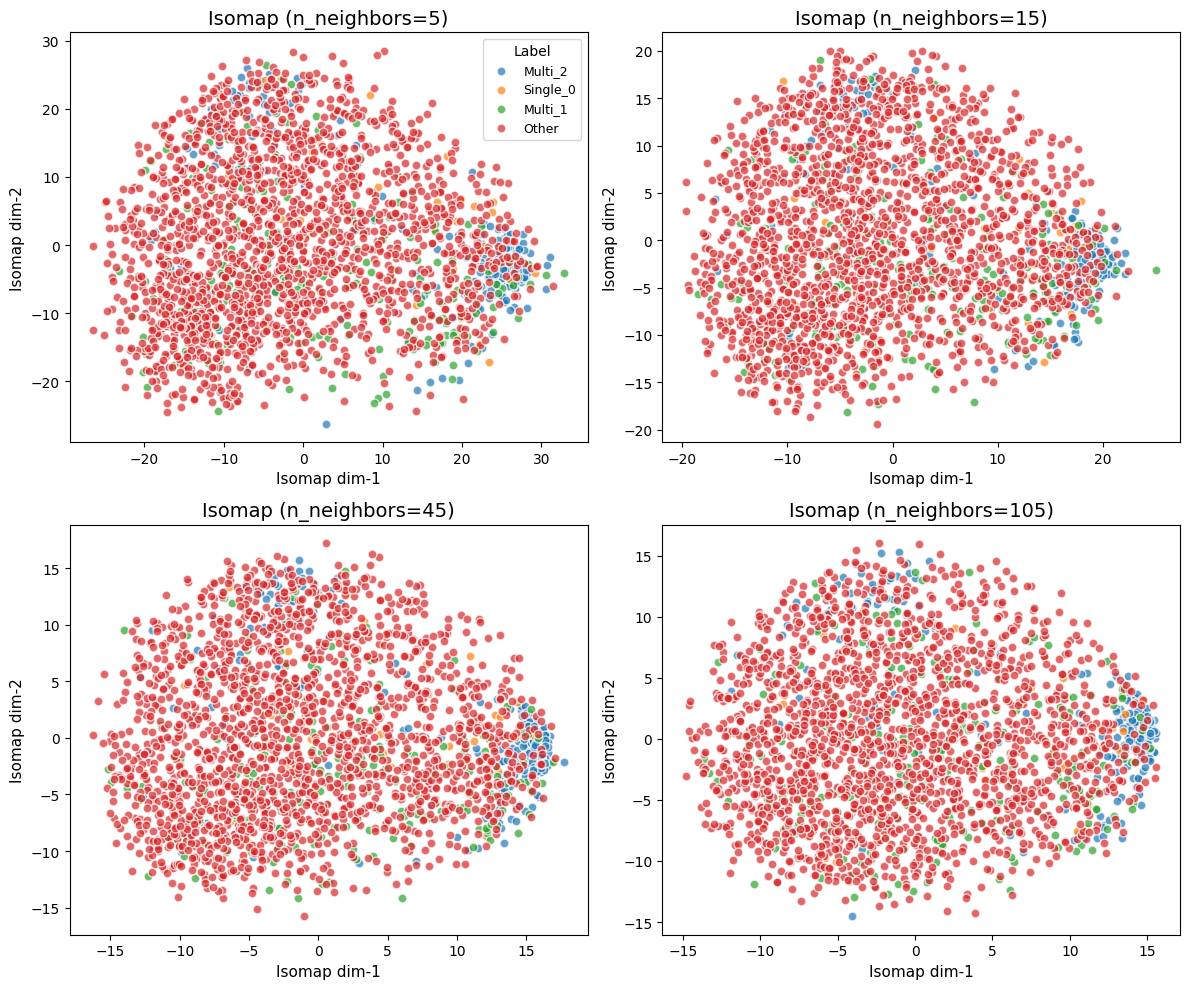

In [101]:
neighbors_list = [5, 15, 45, 105]
unique_labels = list(set(new_target))
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.flatten()  # Ensures we can index axes[0], axes[1], etc.

for idx, n in enumerate(neighbors_list):
    isomap = Isomap(n_neighbors=n, n_components=2)
    X_iso = isomap.fit_transform(X_scaled)
    ax = axes[idx]
    for cat in unique_labels:
        mask = np.array(new_target) == cat
        ax.scatter(X_iso[mask, 0], X_iso[mask, 1],
                   color=color_map[cat], label=cat, alpha=0.7, edgecolors='w', s=40)
    ax.set_title(f'Isomap (n_neighbors={n})', fontsize=14)
    ax.set_xlabel('Isomap dim-1', fontsize=11)
    ax.set_ylabel('Isomap dim-2', fontsize=11)
    if idx == 0:
        ax.legend(fontsize=9, title="Label")

plt.tight_layout()
plt.show()

**Conclusion**: n_neighbors = 45 provides the most meaningful and interpretable visualization, neither too local nor too global, faithfully reflecting the structure of the data manifold.

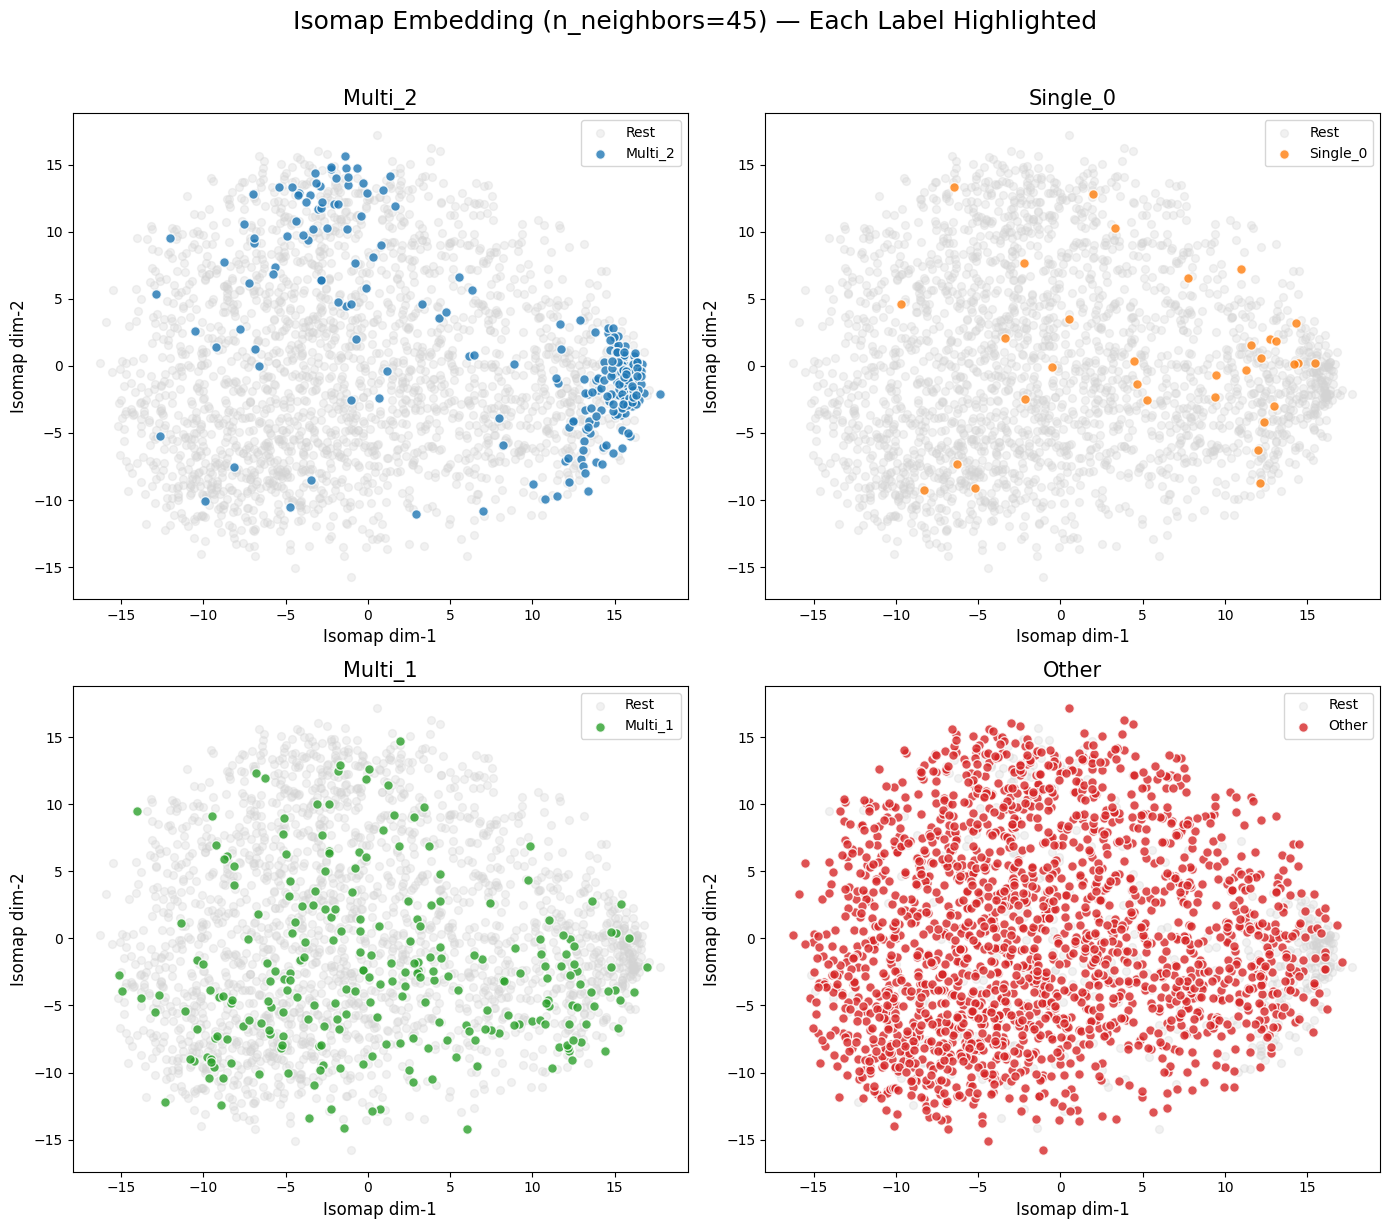

In [102]:
# Choose n_neighbors value (e.g., 45 for best results)
n = 45
isomap = Isomap(n_neighbors=n, n_components=2)
X_iso = isomap.fit_transform(X_scaled)

unique_labels = list(set(new_target))
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, label in enumerate(unique_labels):
    ax = axes[idx]
    mask = np.array(new_target) == label
    # Plot background points in gray
    ax.scatter(X_iso[~mask, 0], X_iso[~mask, 1],
               color="lightgray", alpha=0.3, s=32, label="Rest")
    # Highlight only this label
    ax.scatter(X_iso[mask, 0], X_iso[mask, 1],
               color=color_map[label], alpha=0.8, s=48, edgecolors='w', label=label)
    ax.set_title(f'{label}', fontsize=15)
    ax.set_xlabel('Isomap dim-1', fontsize=12)
    ax.set_ylabel('Isomap dim-2', fontsize=12)
    ax.legend()

plt.suptitle(f"Isomap Embedding (n_neighbors={n}) — Each Label Highlighted", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

The fundamental difference between Isomap and t-SNE lies in how they preserve the structure of data during dimensionality reduction are:

> Isomap is designed to preserve the global structure of the data. It maintains geodesic (manifold-based) distances between all data points, capturing large-scale relationships and the overall shape of the data manifold. This means the distances between both nearby and distant points are retained as much as possible, offering a global view of how all samples are arranged relative to one another.

> t-SNE, on the other hand, places much greater emphasis on preserving the local structure. It aims to keep neighboring points close together in the low-dimensional embedding, faithfully representing small local similarities or clusters. However, it does not explicitly maintain global relationships—distances between distant clusters or points are not guaranteed to correspond to their high-dimensional analogs. As a result, t-SNE may distort the global arrangement in order to reveal tight and meaningful local groupings.

In practice, we use Isomap to understand the overall manifold and use t-SNE to find local clusters and fine neighborhood relationships

### Comparison & curvature

#### Isomap vs t-SNE: Revealing Global Structure

> **Isomap Visualization**: Isomap is explicitly designed to preserve global geometric relationships. In the Isomap plots, the overall shape remains consistent as the number of neighbors increases. Major groupings and cluster relative positions persist across subplots, making the map’s large-scale geometry more trustworthy. The relative locations of all samples (not just those in tight clusters) are meaningfully preserved, which gives a more faithful view of the global manifold structure of the gene expression data.

> **t-SNE Visualization**: t-SNE focuses on local neighborhood preservation. While it does an excellent job of highlighting tight, dense clusters and separating nearby points of similar labels, it distorts the broader geometry. The spread, orientation, and relative inter-cluster distances change significantly with the perplexity parameter—a strong sign that the global structure is not reliable. Large-scale data relationships may be lost or twisted for the sake of showing clear local groupings.

**Conclusion**: Isomap is better at revealing the global structure of the gene expression data. Its visualizations maintain consistent, broadly meaningful geometric relationships between both clusters and individual data points, while t-SNE sacrifices these for local clarity.

#### The Data Manifold: Complexity and Its Impact

> **Data Manifold Concept**: The “data manifold” refers to the (possibly lower-dimensional) shape within the high-dimensional feature space where the real data lies. If the manifold is flat and simple, linear projections (ex PCAs) suffice; if it is curved or intricate, nonlinear techniques (ex Isomaps, t-SNE) are required.

> **Isomap Plot Interpretation**: The Isomap plots show that while some grouping is evident, the boundaries between major label categories are fuzzy and the embedding isn’t strictly linear—it’s slightly oval and somewhat curved. However, the overall spread is relatively uniform and does not reveal multiple folds, “holes,” or wildly twisted structures. This suggests the underlying manifold is **moderately curved but not excessively complex**.

#### Manifold Complexity & Classification Difficulty: 

If the manifold were highly curved or knotted (e.g., resembling an “S” or a spiral), complex nonlinear decision boundaries would be essential, and even advanced classifiers might struggle to perform well. Here, the moderate curvature seen in Isomap implies:
	
> Nonlinear methods provide an advantage over linear methods for classification.
	
> However, classification should be tractable with standard nonlinear algorithms (kernel SVMs, neural networks, etc.).
	
> Residual confusion between overlapping classes is still visible, indicating that some local regions are difficult and may have intrinsic ambiguity due to biological or measurement noise, not just manifold curvature.


#### Summary:
- Isomap more faithfully displays the global structure of gene expression data than t-SNE.
- The Isomap embedding suggests a moderately curved data manifold, signaling that while classification may benefit from nonlinear methods, it is not intractably complex.
- The degree of manifold complexity directly impacts how difficult it is to cleanly separate biological classes using classifiers.